In [21]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import json

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

In [9]:
# Cropping and normalization for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
# Data augmentation and normalization for training set
data_augmentation = transforms.Compose([
        transforms.RandomCrop(500),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [12]:
data_dir = '../Datasets/Kaggle/flower-data'
# A map with keys "train" and "val" and values being images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
augmented_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_augmentation)
image_datasets['train'] = torch.utils.data.ConcatDataset([image_datasets['train'], augmented_train_dataset])
# A map with keys "train" and "val" and values being DataLoaders. A DataLoader is an iterable. 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].datasets[0].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
print(image_datasets)
print(dataset_sizes)
print(classes)

{'train': <torch.utils.data.dataset.ConcatDataset object at 0x7f920769e790>, 'val': Dataset ImageFolder
    Number of datapoints: 818
    Root location: ../Datasets/Kaggle/flower-data/val
    StandardTransform
Transform: Compose(
               CenterCrop(size=(500, 500))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
{'train': 13104, 'val': 818}
tensor([64, 84, 79, 29])


## Visualize data

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(36, 12))
    plt.imshow(inp)
    plt.savefig("flowers.png")
    if title is not None:
        plt.title(title, fontsize=36)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [22]:
index_to_name_map = {}
with open("../Datasets/Kaggle/flower-data/index_to_name.json") as json_file:
    index_to_name_map = json.load(json_file)
ordered_flower_names = []
for key in sorted(index_to_name_map.keys()):
    ordered_flower_names.append(index_to_name_map[key])

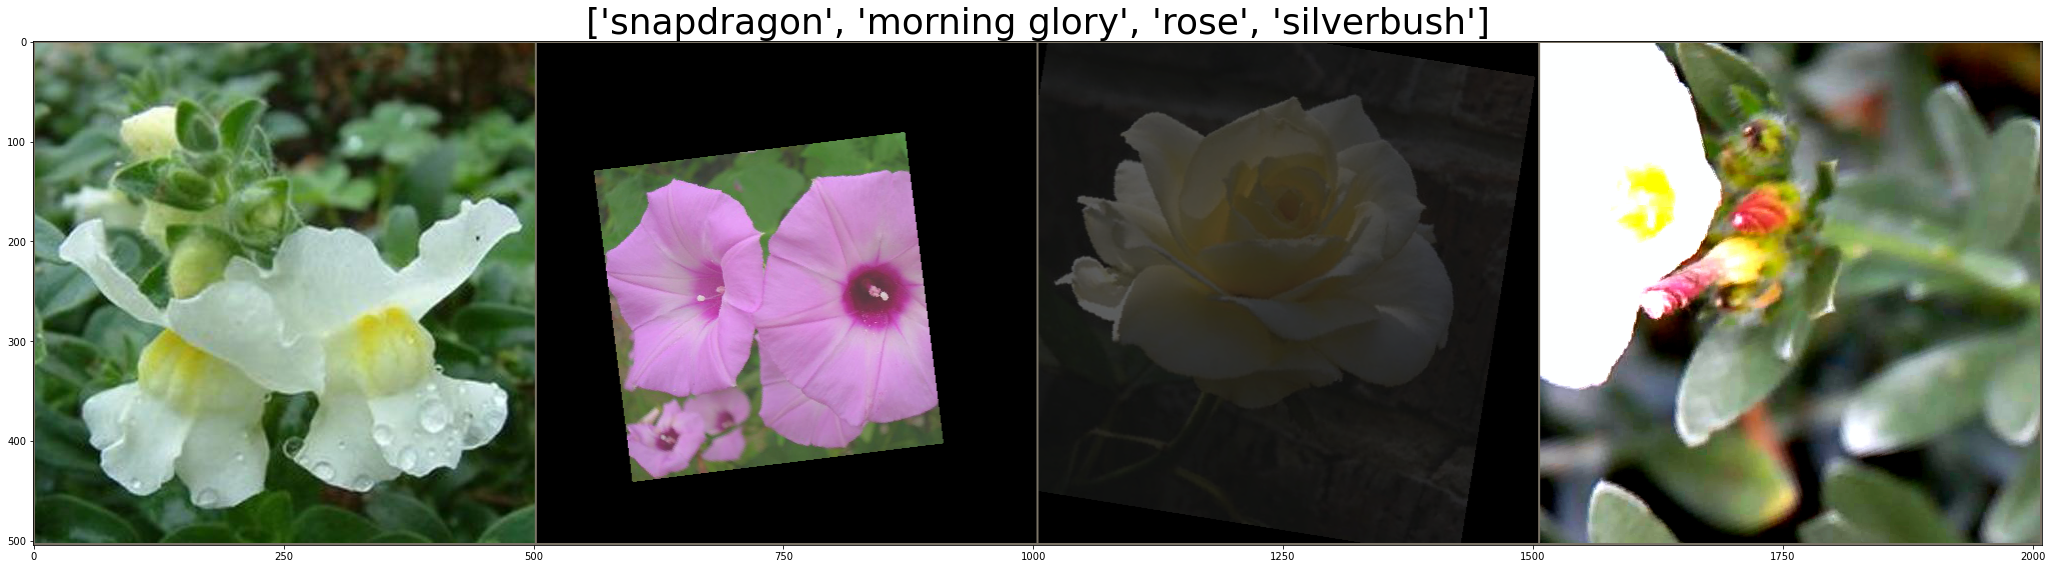

In [40]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch for the visualization purposes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[ordered_flower_names[x] for x in classes])

#### Test

In [63]:
inputs, classes = next(iter(dataloaders["train"]))
print(classes)
print(len(dataloaders["val"]))

tensor([ 76,  73,  65,  68,  98,  47,  22,  78,  25,  51,  84,  99,  51,  77,
         46,  96,  33,  74,  88,  26,  18,  55,  45,  76,  94, 101,  33,  74,
         40,  66,  41,  53,  73,  92,  68,  10,  81,  73,  54,  91,  75,  32,
         76,  41,  36,  67,  97,  89,  74,  40,  38,  79,  99,  97,  56,  55,
         49,  79,  35, 100,  64,  54,  33,  96,   9,  67,  73,  49,  50,   3,
         76,  76,  33,  72,  29,  57,  49,  38,  40,  18,  80,  42,  12,  49,
         77,  11,  49,  18,  87,  49, 101,  79,  43,  81,  38,  54,  78,  78,
         26,  38,  49,  18,  93,  11,  68,  56,  51,  77,  43,  84,  97,  37,
         93,  14,  52,  81,  40,  60,  55,  36,  89,   8,  64,  65,  84,  38,
         12,  90])
7


## Train the model

In [64]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            batch_index = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                
                # Write the loss and accuracy to TensorBoard
                writer.add_scalar('Loss/' + phase, batch_loss, epoch * len(dataloaders[phase]) + batch_index)
                writer.add_scalar('Accuracy/' + phase, batch_corrects / inputs.size(0), epoch * len(dataloaders[phase]) + batch_index)
                
                batch_index += 1
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.flush()
    return model

## Visualize the model predictions

In [65]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        torch.save(model_ft.state_dict(), "saved-models/baseline_resnet18_10epochs_with_dataaugmentation_hyperparamstuned.pth")

## Finetune the ResNet18

In [66]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

num_classes = 102
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

## Train and evaluate

In [67]:
# optimizers = ['SGD', 'Adam', 'RMSprop']
optimizers = ['Adam']
# learning_rates= [5e-3, 1e-3, 5e-2]
learning_rates= [1e-3]
# momentums = [0.9, 0.8]
momentums = [0.9]
batch_sizes = [8, 16, 32, 64, 128, 256]
# step_sizes = [7, 10, 20]
step_sizes = [7]

for optimizer in optimizers:
    for lr in learning_rates:
        for momentum in momentums:
            if optimizer == "SGD":
                optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
            elif optimizer == "Adam":
                optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr)    
            for step_size in step_sizes:
                for batch_size in batch_sizes:
                    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=0.1)
                    # Creates a runs/baseline_resnet18_dataaugmented_hyperparamstuned folder
                    writer = SummaryWriter("TensorBoard/runs/baseline_resnet18_with_dataaugmentation_" + optimizer + "+momentum0.9" + "_lr" + str(lr) + "_batch" + str(batch_size))
                    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                 shuffle=True, num_workers=4) for x in ['train', 'val']}
                    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 10, dataloaders)
                    torch.save(model_ft.state_dict(), "saved-models/baseline_resnet18_10epochs_with_dataaugmentation_" + optimizer + "+momentum0.9" + "_lr" + str(lr) + "_batch"  + str(batch_size) + ".pth")

Epoch 0/9
----------


100%|█████████████████| 1638/1638 [08:11<00:00,  3.33it/s]


train Loss: 4.1544 Acc: 0.0711


100%|███████████████████| 103/103 [00:11<00:00,  8.93it/s]


val Loss: 9.5776 Acc: 0.1015

Epoch 1/9
----------


100%|█████████████████| 1638/1638 [08:09<00:00,  3.35it/s]


train Loss: 3.5541 Acc: 0.1397


100%|███████████████████| 103/103 [00:11<00:00,  8.94it/s]


val Loss: 3.5271 Acc: 0.2579

Epoch 2/9
----------


100%|█████████████████| 1638/1638 [08:12<00:00,  3.33it/s]


train Loss: 3.0709 Acc: 0.2313


100%|███████████████████| 103/103 [00:11<00:00,  8.93it/s]


val Loss: 2.8295 Acc: 0.3386

Epoch 3/9
----------


100%|█████████████████| 1638/1638 [08:09<00:00,  3.35it/s]


train Loss: 2.5461 Acc: 0.3377


100%|███████████████████| 103/103 [00:11<00:00,  8.97it/s]


val Loss: 2.7745 Acc: 0.4315

Epoch 4/9
----------


100%|█████████████████| 1638/1638 [08:08<00:00,  3.35it/s]


train Loss: 2.0853 Acc: 0.4398


100%|███████████████████| 103/103 [00:11<00:00,  8.93it/s]


val Loss: 1.5168 Acc: 0.5990

Epoch 5/9
----------


100%|█████████████████| 1638/1638 [08:11<00:00,  3.33it/s]


train Loss: 1.7860 Acc: 0.5187


100%|███████████████████| 103/103 [00:11<00:00,  8.98it/s]


val Loss: 1.3615 Acc: 0.6430

Epoch 6/9
----------


100%|█████████████████| 1638/1638 [08:08<00:00,  3.35it/s]


train Loss: 1.4947 Acc: 0.5881


100%|███████████████████| 103/103 [00:11<00:00,  8.94it/s]


val Loss: 1.0632 Acc: 0.7139

Epoch 7/9
----------


100%|█████████████████| 1638/1638 [08:09<00:00,  3.35it/s]


train Loss: 1.0499 Acc: 0.7129


100%|███████████████████| 103/103 [00:11<00:00,  8.89it/s]


val Loss: 0.8349 Acc: 0.7885

Epoch 8/9
----------


100%|█████████████████| 1638/1638 [08:09<00:00,  3.35it/s]


train Loss: 0.9248 Acc: 0.7466


100%|███████████████████| 103/103 [00:11<00:00,  8.92it/s]


val Loss: 0.7841 Acc: 0.8068

Epoch 9/9
----------


100%|█████████████████| 1638/1638 [08:08<00:00,  3.35it/s]


train Loss: 0.8826 Acc: 0.7585


100%|███████████████████| 103/103 [00:11<00:00,  8.94it/s]


val Loss: 0.7310 Acc: 0.8056

Training complete in 83m 35s
Best val Acc: 0.806846
Epoch 0/9
----------


  0%|                             | 0/819 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.17 GiB total capacity; 10.66 GiB already allocated; 5.88 MiB free; 10.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
visualize_model(model_ft)

## Save Model

In [ ]:
torch.save(model_ft.state_dict(), "saved-models/baseline_resnet18_10epochs_with_dataaugmentation_hyperparamstuned.pth")

## Close the TensorBoard summary writer

In [ ]:
writer.close()

## Reference

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html